In [314]:
%matplotlib inline
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

In [315]:
df = pd.read_csv('data.csv', sep=',')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [316]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [317]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == "No Offer" else 1)
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
5,6,134.83,0,1,Surburban,0,Phone,1,1
6,9,280.20,1,0,Surburban,1,Phone,1,0
7,9,46.42,0,1,Urban,0,Phone,1,0
8,9,675.07,1,1,Rural,1,Phone,1,0
9,10,32.84,0,1,Urban,1,Web,1,0


In [318]:
# Преобразование столбца channel в бинарный вид
df['channel_Phone'] = df['channel'].apply(lambda x: 1 if x == 'Phone' else 0)
df['channel_Web'] = df['channel'].apply(lambda x: 1 if x == 'Web' else 0)
df['channel_Multichannel'] = df['channel'].apply(lambda x: 1 if x == 'Multichannel' else 0)

# Удаление исходного столбца channel
df.drop('channel', axis=1, inplace=True)

In [319]:
cat_features = ['zip_code']

In [320]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.3,  
                                                    random_state=42,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

In [321]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [322]:
# Создаем пустой датафрейм для хранения результатов
results_df = pd.DataFrame(columns=['models', 'uplift@10%', 'uplift@20%'])

### 1. Подходы с одной моделью

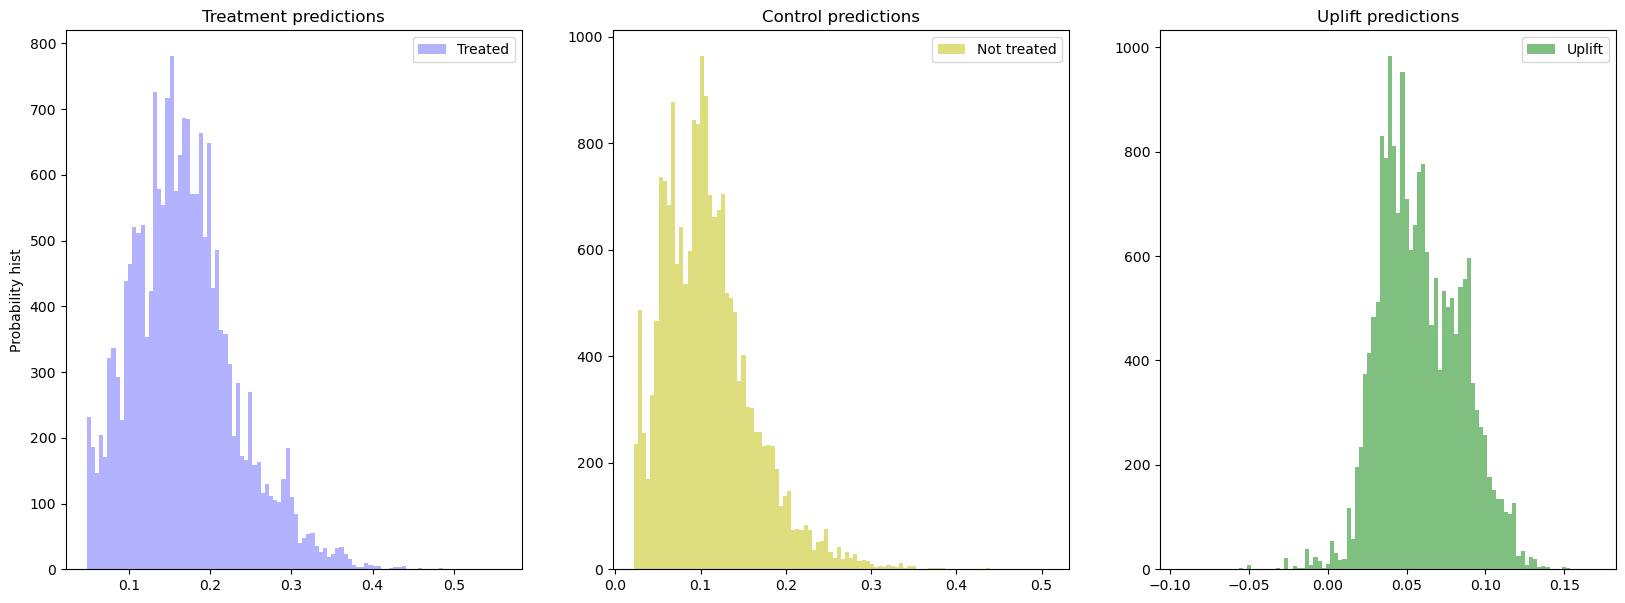

In [323]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)


results_df = results_df.append({
    'models': 'SoloModel',
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20
}, ignore_index=True)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [324]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,17.064448
1,treatment,16.640195
2,recency,14.463657
3,used_bogo,13.095580
4,zip_code,11.120843
5,history,9.679148
6,used_discount,8.196868
7,channel_Phone,5.380582
8,channel_Web,3.569374
9,channel_Multichannel,0.789305


### 2. Трансформация классов


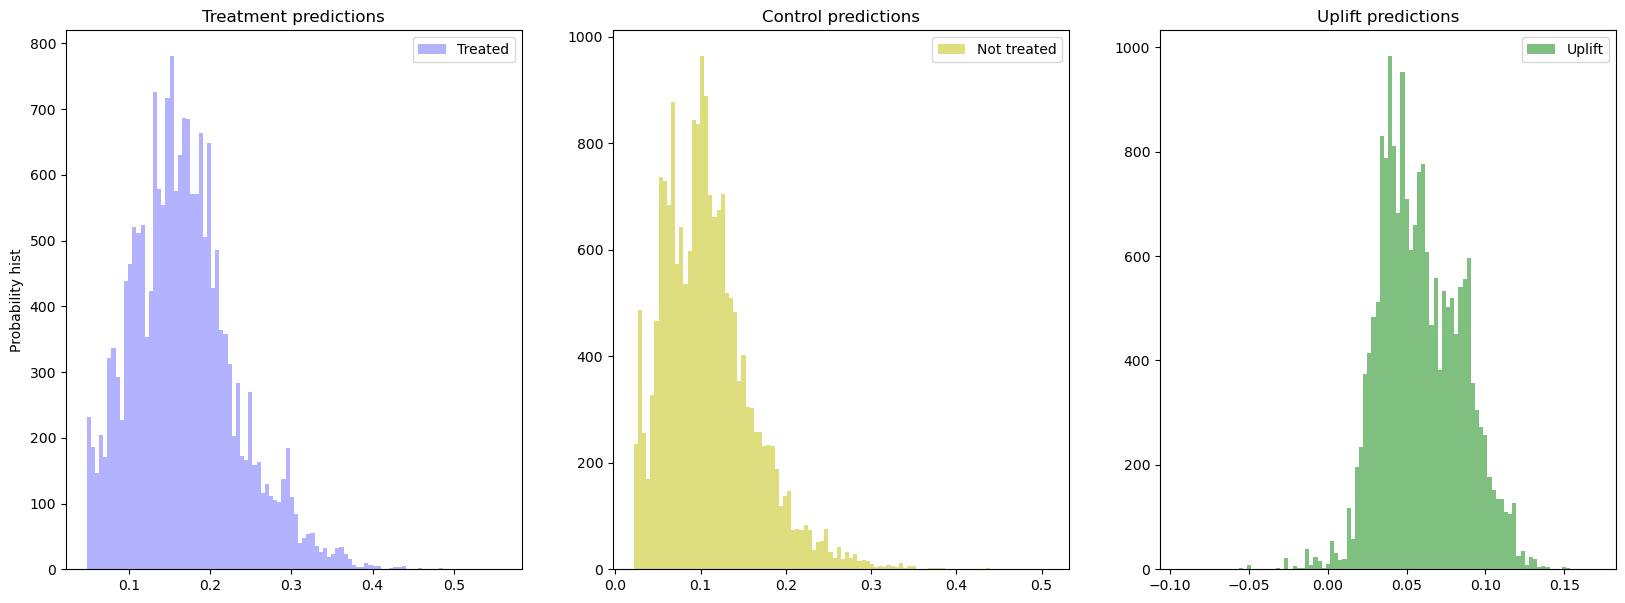

In [325]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

#ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


results_df = results_df.append({
    'models': 'ClassTransform',
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20
}, ignore_index=True)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

### 3. Две независимые модели


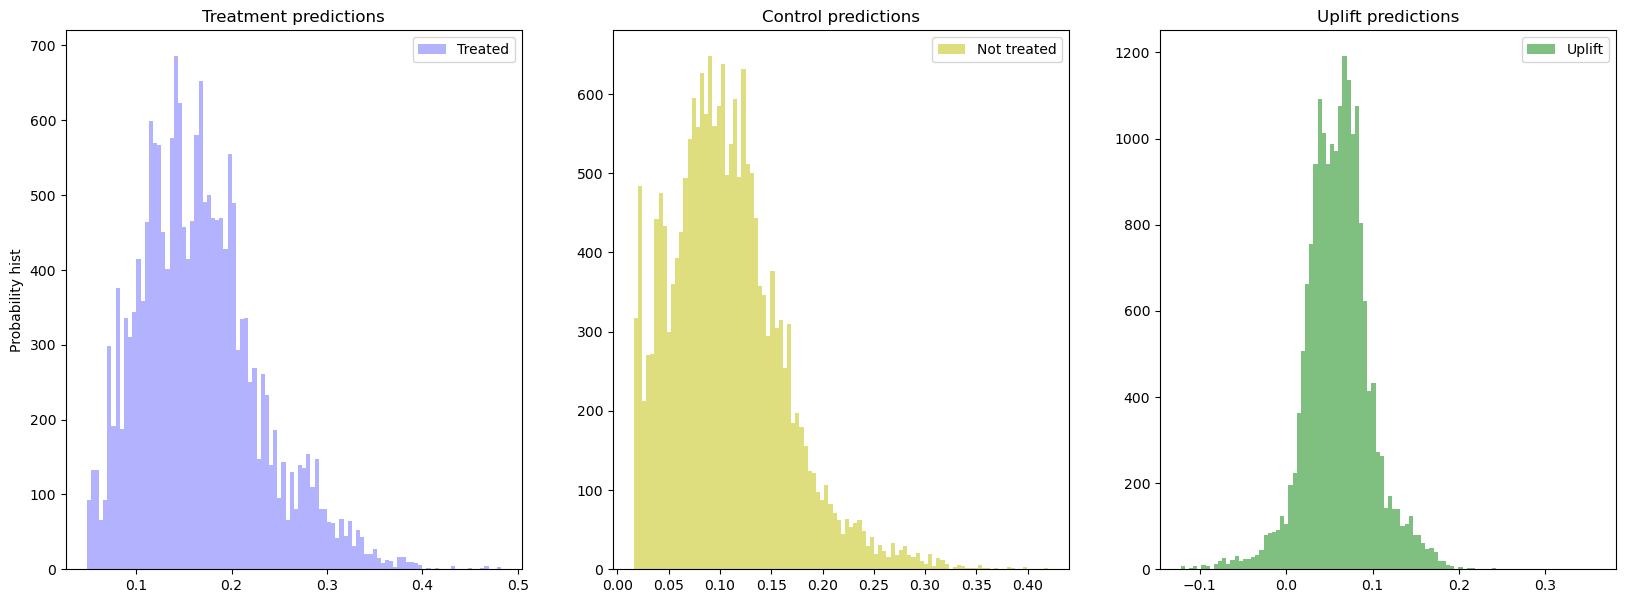

In [326]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)


results_df = results_df.append({
    'models': 'TwoModels',
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [327]:
results_df

,models,uplift@10%,uplift@20%
0,SoloModel,0.086440,0.075639
1,ClassTransform,0.104993,0.086218
2,TwoModels,0.085764,0.085764


### Наблюдение

Если channel преобразовать в бинарный вид, то модель SoloModel имеет лучший показатель uplift.

Если channel внести в cat_features, то лучшая модель ClassTransform.

#### почему?

### построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [352]:
df = pd.read_csv('data.csv', sep=',')

In [353]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [354]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == "No Offer" else 1)

In [355]:
# Преобразование столбца channel в бинарный вид
df['channel_Phone'] = df['channel'].apply(lambda x: 1 if x == 'Phone' else 0)
df['channel_Web'] = df['channel'].apply(lambda x: 1 if x == 'Web' else 0)
df['channel_Multichannel'] = df['channel'].apply(lambda x: 1 if x == 'Multichannel' else 0)

# Удаление исходного столбца channel
df.drop('channel', axis=1, inplace=True)

In [358]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel_Phone,channel_Web,channel_Multichannel
23097,5,954.34,1,1,Urban,1,0,0,1
22345,9,35.45,1,0,Surburban,1,0,1,0
35583,9,49.92,1,0,Surburban,1,1,0,0
12358,1,769.90,1,1,Urban,1,0,1,0
52275,6,756.69,0,1,Urban,1,0,1,0
...,...,...,...,...,...,...,...,...,...
29962,2,288.16,1,1,Urban,1,0,1,0
4734,1,324.67,1,1,Surburban,0,0,1,0
3437,11,256.08,0,1,Surburban,1,0,1,0
27103,5,37.87,0,1,Urban,1,0,1,0


In [356]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
features = [col for col in X_train_tree]

In [360]:
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

SystemError: initialization of _internal failed without raising an exception